# Laboratorio 3

Sean bienvenidos de nuevo al laboratorio 3 de Deep Learning y Sistemas Inteligentes. Así como en los laboratorios pasados, espero que esta ejercitación les sirva para consolidar sus conocimientos en el tema de Redes Neuronales Recurrentes y LSTM.

Este laboratorio consta de dos partes. En la primera trabajaremos una Red Neuronal Recurrente paso-a-paso. En la segunda fase, usaremos PyTorch para crear una nueva Red Neuronal pero con LSTM, con la finalidad de que no solo sepan que existe cierta función sino también entender qué hace en un poco más de detalle. 

Para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

Espero que esta vez si se muestren los *marks*. De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
#!pip install scikit-image
#!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [3]:
# Seeds
seed_ = 2023
np.random.seed(seed_)

In [4]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [5]:
carne_1 = "22434"
firma_mecanografiada_1 = "Nelson García"
carne_2 = "22296"
firma_mecanografiada_2 = "Joaquín Puente"


In [6]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

## Parte 1 - Construyendo una Red Neuronal Recurrente

**Créditos:** La primera parte de este laboratorio está tomado y basado en uno de los laboratorios dados dentro del curso de "Deep Learning" de Jes Frellsen (DeepLearningDTU)

La aplicación de los datos secuenciales pueden ir desde predicción del clima hasta trabajar con lenguaje natural. En este laboratorio daremos un vistazo a como las RNN pueden ser usadas dentro del modelaje del lenguaje, es decir, trataremos de predecir el siguiente token dada una secuencia. En el campo de NLP, un token puede ser un caracter o bien una palabra.

### Representanción de Tokens o Texto

Como bien hemos hablado varias veces, la computadora no entiende palabras ni mucho menos oraciones completas en la misma forma que nuestros cerebros lo hacen. Por ello, debemos encontrar alguna forma de representar palabras o caracteres en una manera que la computadora sea capaz de interpretarla, es decir, con números. Hay varias formas de representar un grupo de palabras de forma numérica, pero para fines de este laboratorio vamos a centrarnos en una manera común, llamada "one-hot encoding". 

#### One Hot Encoding
Esta técnica debe resultarles familiar de cursos pasados, donde se tomaba una conjunto de categorías y se les asignaba una columna por categoría, entonces se coloca un 1 si el row que estamos evaluando es parte de esa categoría o un 0 en caso contrario. Este mismo acercamiento podemos tomarlo para representar conjuntos de palabras. Por ejemplo

```
casa = [1, 0, 0, ..., 0]
perro = [0, 1, 0, ..., 0]
```

Representar un vocabulario grande con one-hot enconding, suele volverse ineficiente debido al tamaño de cada vector disperso. Para solventar esto, una práctica común es truncar el vocabulario para contener las palabras más utilizadas y representar el resto con un símbolo especial, UNK, para definir palabras "desconocidas" o "sin importancia". A menudo esto se hace que palabras tales como nombres se vean como UNK porque son raros.

### Generando el Dataset a Usar

Para este laboratorio usaremos un dataset simplificado, del cual debería ser más sencillo el aprender de él. Estaremos generando secuencias de la forma

```
a b EOS
a a a a b b b b EOS
```

Noten la aparición del token "EOS", el cual es un caracter especial que denota el fin de la secuencia. Nuestro task en general será el predecir el siguiente token $t_n$, donde este podrá ser "a", "b", "EOS", o "UNK" dada una secuencia de forma ${t_1 , ... , t_{n-1}}$.

In [7]:
# Reseed the cell
np.random.seed(seed_)

def generate_data(num_seq=100):
    """
    Genera un grupo de secuencias, la cantidad de secuencias es dada por num_seq
    
    Args:
    num_seq: El número de secuencias a ser generadas
    
    Returns:
    Una lista de secuencias
    """
    samples = []
    for i in range(num_seq):
        # Genera una secuencia de largo aleatorio
        num_tokens = np.random.randint(1,12) 
        # Genera la muestra
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        # Agregamos
        samples.append(sample)
    return samples

sequences = generate_data()
print("Una secuencia del grupo generado")
print(sequences[0])

Una secuencia del grupo generado
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


### Representación de tokens como índices

En este paso haremos la parte del one-hot encoding. Para esto necesitaremos asignar a cada posible palabra de nuestro vocabulario un índice. Para esto crearemos dos diccionarios, uno que permitirá que dada una palabra nos dirá su representación como "indice" en el vocabulario, y el segundo que irá en dirección contraria. 

A estos les llamaremos `word_to_idx` y `idx_to_word`. La variable `vocab_size` nos dirá el máximo de tamaño de nuestro vocabulario. Si intentamos acceder a una palabra que no está en nuestro vocabulario, entonces se le reemplazará con el token "UNK" o su índice correspondiente.

In [8]:
def seqs_to_dicts(sequences):
    """
    Crea word_to_idx y idx_to_word para una lista de secuencias
    
    Args:
    sequences: lista de secuencias a usar
    
    Returns:
    Diccionario de palabra a indice
    Diccionario de indice a palabra
    Int numero de secuencias
    Int tamaño del vocabulario
    """
    
    # Lambda para aplanar (flatten) una lista de listas
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Aplanamos el dataset
    all_words = flatten(sequences)
    
    # Conteo de las ocurrencias de las palabras
    word_count = defaultdict(int)
    for word in all_words:
        word_count[word] += 1
        
    # Ordenar por frecuencia
    word_count = sorted(list(word_count.items()), key=lambda x: -x[1])
    
    # Crear una lista de todas las palabras únicas
    unique_words = [w[0] for w in word_count]
    
    # Agregamos UNK a la lista de palabras
    unique_words.append("UNK")
    
    # Conteo del número de secuencias y el número de palabras unicas
    num_sentences, vocab_size = len(sequences), len(unique_words)
    
    # Crear diccionarios mencionados
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')
    
    # Llenado de diccionarios
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word
        
    return word_to_idx, idx_to_word, num_sentences, vocab_size

word_to_idx, idx_to_word, num_sequences, vocab_size = seqs_to_dicts(sequences)

print(f"Tenemos {num_sequences} secuencias y {len(word_to_idx)} tokens unicos incluyendo UNK")
print(f"El indice de 'b' es {word_to_idx['b']}")
print(f"La palabra con indice 1 es {idx_to_word[1]}")

Tenemos 100 secuencias y 4 tokens unicos incluyendo UNK
El indice de 'b' es 1
La palabra con indice 1 es b


In [9]:
with tick.marks(3):        
    assert(check_scalar(len(word_to_idx), '0xc51b9ba8'))
    
with tick.marks(2):        
    assert(check_scalar(len(idx_to_word), '0xc51b9ba8'))
    
with tick.marks(5):        
    assert(check_string(idx_to_word[0], '0xe8b7be43'))

### Representación de tokens como índices

Como bien sabemos, necesitamos crear nuestro dataset de forma que el se divida en inputs y targets para cada secuencia y luego particionar esto en training, validation y test (80%, 10%, 10%). Debido a que estamso haciendo prediccion de la siguiente palabra, nuestro target es el input movido (shifted) una palabra.

Vamos a usar PyTorch solo para crear el dataset (como lo hicimos con las imagenes de perritos y gatitos de los laboratorios pasados). Aunque esta vez no haremos el dataloader. Recuerden que siempre es buena idea usar un DataLoader para obtener los datos de una forma eficienciente, al ser este un generador/iterador. Además, este nos sirve para obtener la información en batches.

In [10]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    # Definimos el tamaño de las particiones
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Dividir las secuencias en las particiones
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    # Funcion interna para obtener los targets de una secuencia
    def get_inputs_targets_from_sequences(sequences):
        # Listas vacias
        inputs, targets = [], []
        
        # Agregar informacion a las listas, ambas listas tienen L-1 palabras de una secuencia de largo L
        # pero los targetes están movidos a la derecha por uno, para que podamos predecir la siguiente palabra
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Obtener inputs y targes para cada subgrupo
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Creación de datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f"Largo del training set {len(training_set)}")
print(f"Largo del validation set {len(validation_set)}")
print(f"Largo del test set {len(test_set)}")

Largo del training set 80
Largo del validation set 10
Largo del test set 10


### One-Hot Encodings

Ahora creemos una función simple para obtener la representación one-hot encoding de dado un índice de una palabra. Noten que el tamaño del one-hot encoding es igual a la del vocabulario. Adicionalmente definamos una función para encodear una secuencia. 

In [11]:
def one_hot_encode(idx, vocab_size):
    """
    Encodea una sola palabra dado su indice y el tamaño del vocabulario
    
    Args:
     idx: indice de la palabra 
     vocab_size: tamaño del vocabulario
    
    Returns
    np.array de lagro "vocab_size"
    """
    # Init array encodeado
    one_hot = np.zeros(vocab_size)
    
    # Setamos el elemento a uno
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    Encodea una secuencia de palabras dado el tamaño del vocabulario
    
    Args:
     sentence: una lista de palabras a encodear
     vocab_size: tamaño del vocabulario
     
    Returns
    np.array 3D de tamaño (numero de palabras, vocab_size, 1)
    """
    # Encodear cada palabra en la secuencia
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Cambiar de forma para tener (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding

test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f"Encodeado de 'a' con forma {test_word.shape}")

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f"Encodeado de la secuencia 'a b' con forma {test_sentence.shape}.")

Encodeado de 'a' con forma (4,)
Encodeado de la secuencia 'a b' con forma (2, 4, 1).


Ahora que ya tenemos lo necesario de data para empezar a trabajar, demos paso a hablar un poco más de las RNN

## Redes Neuronales Recurrentes (RNN)

Una red neuronal recurrente (RNN) es una red neuronal conocida por modelar de manera efectiva datos secuenciales como el lenguaje, el habla y las secuencias de proteínas. Procesa datos de manera cíclica, aplicando los mismos cálculos a cada elemento de una secuencia. Este enfoque cíclico permite que la red utilice cálculos anteriores como una forma de memoria, lo que ayuda a hacer predicciones para cálculos futuros. Para comprender mejor este concepto, consideren la siguiente imagen.


<img src="https://media.geeksforgeeks.org/wp-content/uploads/20230518134831/What-is-Recurrent-Neural-Network.webp" alt="RNN" />

*Crédito de imagen al autor, imagen tomada de "Introduction to Recurrent Neural Network" de Aishwarya.27*

Donde:
* $x$ es la secuencia de input
* $U$ es una matriz de pesos aplicada a una muestra de input dada
* $V$ es una matriz de pesos usada para la computación recurrente para pasar la memroia en las secuencias
* $W$ es una matriz de pesos usada para calcular la salida de cada paso
* $h$ es el estado oculto (hidden state) (memoria de la red) para cada paso 
* $L$ es la salida resultante

Cuando una red es extendida como se muestra, es más facil referirse a un paso $t$. Tenemos los siguientes calculos en la red

* $h_t=f(U x_t + V h_{t-1}$ donde f es la función de activacion
* $L_t = softmax(W h_t)$

### Implementando una RNN

Ahora pasaremos a inicializar nuestra RNN. Los pesos suelen inicializar de forma aleatoria, pero esta vez lo haremos de forma ortogonal para mejorar el rendimiento de nuestra red, y siguiendo las recomendaciones del paper dado abajo. 

Tenga cuidado al definir los elementos que se le piden, debido a que una mala dimensión causará que tenga resultados diferentes y errores al operar.

In [12]:
np.random.seed(seed_)

hidden_size = 50 # Numero de dimensiones en el hidden state
vocab_size  = len(word_to_idx) # Tamaño del vocabulario

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    Inicializa los pesos ortogonalmente
    
    Esta inicialización está dada por el siguiente paper:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Calcular factorización QR
    q, r = np.linalg.qr(new_param)
    
    # Hacer Q uniforme de acuerdo a https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Inicializa la RNN

    Args:
     hidden_size:  Dimensiones del hidden state
     vocab_size: Dimensión del vocabulario
    """
    # Inicializamos las matrices de pesos con ceros (luego serán ortogonalizadas)
    U = np.zeros((hidden_size, vocab_size))       # input -> hidden
    V = np.zeros((hidden_size, hidden_size))      # hidden -> hidden
    W = np.zeros((vocab_size, hidden_size))       # hidden -> output

    # Inicializamos los bias con ceros
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))

    # Inicialización ortogonal de pesos
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)

    return U, V, W, b_hidden, b_out

# Inicializamos los parámetros
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Verificación de dimensiones
U, V, W, b_hidden, b_out = params
print(f"U shape: {U.shape}")
print(f"V shape: {V.shape}")
print(f"W shape: {W.shape}")
print(f"b_hidden shape: {b_hidden.shape}")
print(f"b_out shape: {b_out.shape}")


U shape: (50, 4)
V shape: (50, 50)
W shape: (4, 50)
b_hidden shape: (50, 1)
b_out shape: (4, 1)


In [13]:
with tick.marks(5):        
    assert check_hash(params[0], ((50, 4), 80.24369675632171))
    
with tick.marks(5):        
    assert check_hash(params[1], ((50, 50), 3333.838548574836))
    
with tick.marks(5):        
    assert check_hash(params[2], ((4, 50), -80.6410290517092))
    
with tick.marks(5):        
    assert check_hash(params[3], ((50, 1), 0.0))
    
with tick.marks(5):        
    assert check_hash(params[4], ((4, 1), 0.0))

#### Funciones de Activación
A continuación definiremos las funciones de activación a usar, sigmoide, tanh y softmax. 

In [14]:
def sigmoid(x, derivative=False):
    """
    Calcula la función sigmoide para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x + 1e-12  # Evitar ceros
    f = 1 / (1 + np.exp(-x_safe))  # Función sigmoide
    
    # Regresa la derivada de la función
    if derivative: 
        return f * (1 - f)
    else: 
        return f
    
def tanh(x, derivative=False):
    """
    Calcula la función tanh para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x + 1e-12  # Evitar ceros
    f = np.tanh(x_safe)  # Función tanh
    
    # Regresa la derivada de la función
    if derivative: 
        return 1 - f**2
    else: 
        return f
    
def softmax(x, derivative=False):
    """
    Calcula la función softmax para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x - np.max(x)  # Estabilización numérica
    f = np.exp(x_safe) / np.sum(np.exp(x_safe), axis=0, keepdims=True)
    
    # No se necesita derivada explícita del softmax
    if derivative: 
        pass
    else: 
        return f


In [15]:
with tick.marks(5):        
    assert check_hash(sigmoid(params[0][0]), ((4,), 6.997641543410888))
    
with tick.marks(5):        
    assert check_hash(tanh(params[0][0]), ((4,), -0.007401604025076086))
    
with tick.marks(5):        
    assert check_hash(softmax(params[0][0]), ((4,), 3.504688021096135))

#### Implementación del paso Forward
Ahora es el momento de implementar el paso forward usando lo que hemos implementado hasta ahora

In [16]:
def forward_pass(inputs, hidden_state, params):
    """
    Calcula el paso forward de RNN

    Args:
     inputs: Secuencia de input a ser procesada (lista de vectores one-hot)
     hidden_state: Un estado inicializado hidden state (vector columna)
     params: Parámetros de la RNN (U, V, W, b_hidden, b_out)
    """
    # Obtener los parámetros
    U, V, W, b_hidden, b_out = params

    # Crear listas para guardar las salidas y los hidden states
    outputs, hidden_states = [], []

    # Para cada elemento en la secuencia input
    for t in range(len(inputs)):
        x_t = inputs[t]  # Vector one-hot de entrada en t (shape: vocab_size x 1)

        # Calculo del nuevo hidden state: tanh(Ux + Vh + b)
        hidden_state = tanh(np.dot(U, x_t) + np.dot(V, hidden_state) + b_hidden)

        # Cálculo del output: softmax(Wh + b)
        out = softmax(np.dot(W, hidden_state) + b_out)

        # Guardar
        outputs.append(out)
        hidden_states.append(hidden_state.copy())

    return outputs, hidden_states


In [17]:
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode 
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Init hidden state con zeros
hidden_state = np.zeros((hidden_size, 1))

outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print("Secuencia Input:")
print(test_input_sequence)

print("Secuencia Target:")
print(test_target_sequence)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

with tick.marks(5):        
    assert check_hash(outputs, ((16, 4, 1), 519.7419046193046))

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'b', 'a', 'a', 'a', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'b', 'b', 'b', 'b']


#### Implementación del paso Backward

Ahora es momento de implementar el paso backward.
Si se pierden, remitanse a las ecuaciones e imagen dadas previamente.

Usaremos una función auxiliar para evitar la explición del gradiente. Esta tecnica suele funcionar muy bien, si quieren leer más sobre esto pueden consultar estos enlances

[Understanding Gradient Clipping (and How It Can Fix Exploding Gradients Problem)](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)

[What exactly happens in gradient clipping by norm?](https://ai.stackexchange.com/questions/31991/what-exactly-happens-in-gradient-clipping-by-norm)

In [18]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clipea (recorta?) el gradiente para tener una norma máxima de `max_norm`
    Esto ayudará a prevenir el problema de la gradiente explosiva (BOOM!)
    """ 
    # Setea el máximo de la norma para que sea flotante
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculamos la norma L2 al cuadrado para cada gradiente y agregamos estas a la norma total
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    # Cuadrado de la normal total
    total_norm = np.sqrt(total_norm)
    
    # Calculamos el coeficiente de recorte
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # Si el total de la norma es más grande que el máximo permitido, se recorta la gradiente
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    return grads
    
def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Calcula el paso backward de la RNN
    
    Args:
     inputs: secuencia de input
     outputs: secuencia de output del forward
     hidden_states: secuencia de los hidden_state del forward
     targets: secuencia target
     params: parametros de la RNN
    """
    
    # Obtener los parametros
    U, V, W, b_hidden, b_out = params
    
    # Inicializamos las gradientes como cero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Llevar el record de las derivadas de los hidden state y las perdidas (loss)
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # Iteramos para cada elemento en la secuencia output
    for t in reversed(range(len(outputs))):
        # Calcula la perdida cross-entropy
        loss += -np.sum(targets[t] * np.log(outputs[t] + 1e-12))
        
        # Backpropagate en los output (derivada del cross-entropy)
        d_o = outputs[t] - targets[t]
        
        # Backpropagation de W
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backprop de h
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backprop en la funcion de activacion tanh
        d_f = (1 - hidden_states[t]**2) * d_h
        d_b_hidden += d_f
        
        # Backprop en U
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backprop V
        if t > 0:
            d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Empaquetar las gradientes
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Corte de gradientes
    grads = clip_gradient_norm(grads)
    
    return loss, grads  

    

In [19]:
loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

with tick.marks(5):        
    assert check_scalar(loss, '0xf0c8ccc9')

with tick.marks(5):        
    assert check_hash(grads[0], ((50, 4), -16.16536590645467))
    
with tick.marks(5):        
    assert check_hash(grads[1], ((50, 50), -155.12594909703253))
    
with tick.marks(5):        
    assert check_hash(grads[2], ((4, 50), 1.5957812992239038))

AssertionError: 

#### Optimización

Considerando que ya tenemos el paso forward y podemos calcular gradientes con el backpropagation, ya podemos pasar a entrenar nuestra red. Para esto necesitaremos un optimizador. Una forma común y sencilla es implementar la gradiente descediente. Recuerden la regla de optimizacion
$$
θ = θ - α * ∇J(θ)
$$

* $θ$ son los parametros del modelo
* $α$ es el learning rate
* $∇J(θ)$ representa la gradiente del costo J con respecto de los parametros

In [20]:
def update_parameters(params, grads, lr=1e-3):
    # Iteramos sobre los parametros y las gradientes
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

#### Entrenamiento
Debemos establecer un ciclo de entrenamiento completo que involucre un paso forward, un paso backprop, un paso de optimización y validación. Se espera que el proceso de training dure aproximadamente 5 minutos (o menos), lo que le brinda la oportunidad de continuar leyendo mientras se ejecuta&#x1F61C;	

Noten que estaremos viendo la perdida en el de validación (no en el de testing) esto se suele hacer para ir observando que tan bien va comportandose el modelo en terminos de generalización. Muchas veces es más recomendable ir viendo como evoluciona la métrica de desempeño principal (accuracy, recall, etc).

In [21]:
# Hyperparámetro
num_epochs = 2000  # número de épocas

# Inicializar una nueva RNN
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Inicializar hidden state con ceros
hidden_state = np.zeros((hidden_size, 1))

# Listas para rastrear pérdida en train y validación
training_loss, validation_loss = [], []

for i in range(num_epochs):
    epoch_training_loss = 0.0
    epoch_validation_loss = 0.0

    # —— Validación —— 
    for inputs, targets in validation_set:
        # One-hot encode
        inputs_one_hot  = one_hot_encode_sequence(inputs,  vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Resetear hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass (no actual update)
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        epoch_validation_loss += loss

    # —— Entrenamiento —— 
    for inputs, targets in training_set:
        # One-hot encode
        inputs_one_hot  = one_hot_encode_sequence(inputs,  vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Resetear hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass y obtener gradientes
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)

        # Detectar gradiente desvanecida
        if np.isnan(loss):
            raise ValueError("La gradiente se desvanecio... POOF!")

        # Actualizar parámetros
        params = update_parameters(params, grads, lr=3e-4)

        epoch_training_loss += loss

    # Guardar y promediar pérdidas
    training_loss.append(epoch_training_loss / len(training_set))
    validation_loss.append(epoch_validation_loss / len(validation_set))

    # Mostrar progreso cada 100 épocas
    if i % 100 == 0:
        print(f'Época {i:4d} — training loss: {training_loss[-1]:.4f}, validation loss: {validation_loss[-1]:.4f}')


Época    0 — training loss: 16.2011, validation loss: 19.2079
Época  100 — training loss: 10.7922, validation loss: 12.7806
Época  200 — training loss: 8.2468, validation loss: 9.8295
Época  300 — training loss: 7.0646, validation loss: 8.5729
Época  400 — training loss: 6.4559, validation loss: 7.9775
Época  500 — training loss: 6.0791, validation loss: 7.6198
Época  600 — training loss: 5.7943, validation loss: 7.3398
Época  700 — training loss: 5.5423, validation loss: 7.0769
Época  800 — training loss: 5.2937, validation loss: 6.8045
Época  900 — training loss: 5.0360, validation loss: 6.5188
Época 1000 — training loss: 4.7790, validation loss: 6.2573
Época 1100 — training loss: 4.5628, validation loss: 6.0927
Época 1200 — training loss: 4.4284, validation loss: 6.0632
Época 1300 — training loss: 4.3700, validation loss: 6.1430
Época 1400 — training loss: 4.3318, validation loss: 6.2353
Época 1500 — training loss: 4.2874, validation loss: 6.2893
Época 1600 — training loss: 4.2422, 

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS', 'EOS']


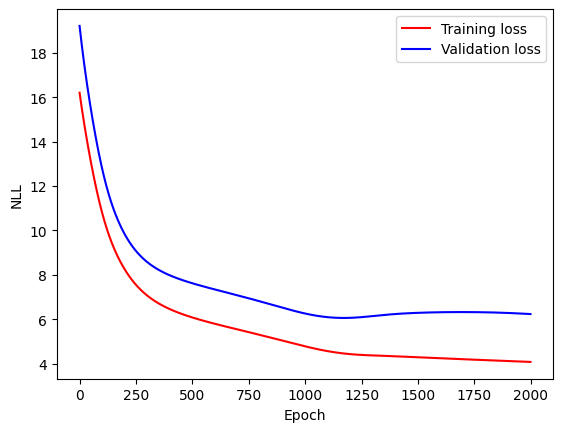

In [22]:
# Veamos la primera secuencia en el test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init el hidden state con ceros
hidden_state = np.zeros((hidden_size, 1))

# Hacemos el pase forward para evalular nuestra secuencia
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

# Graficamos la perdida
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

with tick.marks(10):        
    assert compare_lists_by_percentage(targets, [idx_to_word[np.argmax(output)] for output in outputs], 65)

#### Preguntas

Ya hemos visto el funcionamiento general de nuestra red RNN, viendo las gráficas de arriba, **responda** lo siguiente dentro de esta celda

* ¿Qué interpretación le da a la separación de las graficas de training y validation?
* ¿Cree que es un buen modelo basado solamente en el loss?
* ¿Cómo deberían de verse esas gráficas en un modelo ideal?

## Parte 2 - Construyendo una Red Neuronal LSTM 

**Créditos:** La segunda parte de este laboratorio está tomado y basado en uno de los laboratorios dados dentro del curso de "Deep Learning" de Jes Frellsen (DeepLearningDTU)


Consideren leer el siguiente blog para mejorar el entendimiento de este tema: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

La RNN estándar enfrenta un problema de gradientes que desaparecen, lo que dificulta la retención de memoria en secuencias más largas. Para hacer frente a estos desafíos, se introdujeron algunas variantes. 

Los dos tipos principales son la celda de memoria a corto plazo (LSTM) y la unidad recurrente cerrada (GRU), las cuales demuestran una capacidad mejorada para conservar y utilizar la memoria en pasos de tiempo posteriores. 

En este ejercicio, nuestro enfoque estará en LSTM, pero los principios aprendidos aquí también se pueden aplicar fácilmente para implementar GRU.

Recordemos una de las imagenes que vimos en clase

<img src="https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" alt="LSTM" />

*Crédito de imagen al autor, imagen tomada de "Designing neural network based decoders for surface codes" de Savvas Varsamopoulos*


Recordemos que la "celula" de LST contiene tres tipos de gates, input, forget y output gate. La salida de una unidad LSTM está calculada por las siguientes funciones, donde  $\sigma = softmax$. Entonces tenemos la input gate $i$, la forget gate $f$ y la output gate $o$

* $i = \sigma ( W^i [h_{t-1}, x_t])$
* $f = \sigma ( W^f [h_{t-1},x_t])$
* $o = \sigma ( W^o [h_{t-1},x_t])$

Donde $W^i, W^f, W^o$ son las matrices de pesos aplicada a cada aplicadas a una matriz contatenada $h_{t-1}$ (hidden state vector) y $x_t$ (input vector) para cada respectiva gate $h_{t-1}$, del paso previo junto con el input actual $x_t$ son usados para calcular una memoria candidata $g$

* $g = tanh( W^g [h_{t-1}, x_t])$

El valor de la memoria $c_t$ es actualizada como

$c_t = c_{t-1} \circ f + g \circ i$

donde $c_{t-1}$ es la memoria previa, y $\circ$ es una multiplicacion element-wise (recuerden que este tipo de multiplicación en numpy es con *)

La salida $h_t$ es calculada como

$h_t = tanh(c_t) \circ o$

y este se usa para tanto la salida del paso como para el siguiente paso, mientras $c_t$ es exclusivamente enviado al siguiente paso. Esto hace $c_t$ una memoria feature, y no es usado directamente para caluclar la salida del paso actual.

### Iniciando una Red LSTM

De forma similar a lo que hemos hecho antes, necesitaremos implementar el paso forward, backward y un ciclo de entrenamiento. Pero ahora usaremos LSTM con NumPy. Más adelante veremos como es que esto funciona con PyTorch. 

In [23]:
np.random.seed(seed_)

# Tamaño del hidden state concatenado más el input
z_size = hidden_size + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Inicializa los pesos y sesgos de una LSTM simple.
    
    Args:
      hidden_size: dimensión del hidden state
      vocab_size: tamaño del vocabulario
      z_size: dimensión de la concatenación [h_{t-1}, x_t] = hidden_size + vocab_size
    Returns:
      Pesos W_f, W_i, W_g, W_o, W_v y sesgos b_f, b_i, b_g, b_o, b_v
    """
    # Pesos aleatorios para cada gate (shape: hidden_size x z_size)
    W_f = np.random.randn(hidden_size, z_size)
    b_f = np.zeros((hidden_size, 1))

    W_i = np.random.randn(hidden_size, z_size)
    b_i = np.zeros((hidden_size, 1))

    W_g = np.random.randn(hidden_size, z_size)
    b_g = np.zeros((hidden_size, 1))

    W_o = np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))

    # Pesos aleatorios para la capa de salida (shape: vocab_size x hidden_size)
    W_v = np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))

    # Inicialización ortogonal para mejorar convergencia
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v

# Ejemplo de inicialización
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Verificación de formas
W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = params
print(f"W_f shape: {W_f.shape}, b_f shape: {b_f.shape}")
print(f"W_i shape: {W_i.shape}, b_i shape: {b_i.shape}")
print(f"W_g shape: {W_g.shape}, b_g shape: {b_g.shape}")
print(f"W_o shape: {W_o.shape}, b_o shape: {b_o.shape}")
print(f"W_v shape: {W_v.shape}, b_v shape: {b_v.shape}")


W_f shape: (50, 54), b_f shape: (50, 1)
W_i shape: (50, 54), b_i shape: (50, 1)
W_g shape: (50, 54), b_g shape: (50, 1)
W_o shape: (50, 54), b_o shape: (50, 1)
W_v shape: (4, 50), b_v shape: (4, 1)


In [24]:
with tick.marks(5):        
    assert check_hash(params[0], ((50, 54), -28071.583543573637))
    
with tick.marks(5):        
    assert check_hash(params[1], ((50, 54), -6337.520066952928))
    
with tick.marks(5):        
    assert check_hash(params[2], ((50, 54), -13445.986473992281))
    
with tick.marks(5):        
    assert check_hash(params[3], ((50, 54), 2276.1116210911564))
    
with tick.marks(5):        
    assert check_hash(params[4], ((4, 50), -201.28961326044097))

### Forward

Vamos para adelante con LSTM, al igual que previamente necesitamos implementar las funciones antes mencionadas

In [25]:
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    inputs: lista de vectores one-hot, cada uno shape (vocab_size, 1)
    h_prev: hidden state en el paso t-1, shape (hidden_size, 1)
    C_prev: memoria en el paso t-1, shape (hidden_size, 1)
    p: tupla (W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s
    """
    # Desempacar parámetros
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Listas para almacenar los cálculos
    z_s, f_s, i_s, g_s = [], [], [], []
    C_s, o_s, h_s       = [], [], []
    v_s, output_s       = [], []

    # Guardar estados iniciales
    h_s.append(h_prev)
    C_s.append(C_prev)

    for x in inputs:
        # 1) Concatenar hidden y input
        z = np.vstack((h_prev, x))
        z_s.append(z)

        # 2) Forget gate
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s.append(f)

        # 3) Input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)

        # 4) Memoria candidata
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)

        # 5) Actualizar memoria
        C_prev = f * C_prev + i * g
        C_s.append(C_prev)

        # 6) Output gate
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)

        # 7) Calcular nuevo hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # 8) Logits de salida
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)

        # 9) Softmax final
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


In [26]:
# Obtener la primera secuencia para probar
inputs, targets = test_set[1]

# One-hot encode del input y target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init hidden state con ceros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])


with tick.marks(5):        
    assert check_hash(outputs, ((22, 4, 1), 980.1651308051631))

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS', 'EOS', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


### Backward

Ahora de reversa, al igual que lo hecho antes, necesitamos implementar el paso de backward


In [27]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p):
    """
    Backward pass para LSTM con BPTT y gradient clipping.

    Args:
      z, f, i, g, C, o, h, v, outputs, targets: listas con los valores
        calculados en el forward (ver firma en el notebook).
      p: tupla (W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v)
    Returns:
      loss: float con la cross-entropy loss
      grads: tupla de gradientes en el mismo orden que p
    """
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # inicializar gradientes
    W_f_d = np.zeros_like(W_f);  b_f_d = np.zeros_like(b_f)
    W_i_d = np.zeros_like(W_i);  b_i_d = np.zeros_like(b_i)
    W_g_d = np.zeros_like(W_g);  b_g_d = np.zeros_like(b_g)
    W_o_d = np.zeros_like(W_o);  b_o_d = np.zeros_like(b_o)
    W_v_d = np.zeros_like(W_v);  b_v_d = np.zeros_like(b_v)

    # gradientes "hacia atrás"
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])

    loss = 0.0

    # BPTT
    for t in reversed(range(len(outputs))):
        # 1) cross-entropy loss
        loss += -np.sum(targets[t] * np.log(outputs[t] + 1e-12))

        # 2) gradiente de salida
        dv = outputs[t].copy()
        dv -= targets[t]  # dv = y_pred - y_true

        # 3) gradientes W_v, b_v
        #   h[t+1] es el hidden state correspondiente a output t
        W_v_d += np.dot(dv, h[t+1].T)
        b_v_d += dv

        # 4) backprop al hidden
        dh = np.dot(W_v.T, dv) + dh_next

        # 5) output gate
        #    derivada pre-activación:
        do_pre = dh * np.tanh(C[t+1])
        #    derivada de la sigmoid (o[t] ya es sigmoid aplicado):
        do = do_pre * o[t] * (1 - o[t])
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # 6) gradiente de la celda de memoria
        dC = dC_next + dh * o[t] * (1 - np.tanh(C[t+1])**2)

        # 7) memoria candidata
        dg = dC * i[t]
        dg_act = dg * (1 - g[t]**2)   # derivada de tanh (g[t] ya es tanh aplicado)
        W_g_d += np.dot(dg_act, z[t].T)
        b_g_d += dg_act

        # 8) input gate
        di = dC * g[t]
        di_act = di * i[t] * (1 - i[t])  # derivada de sigmoid (i[t] ya es sigmoid aplicado)
        W_i_d += np.dot(di_act, z[t].T)
        b_i_d += di_act

        # 9) forget gate
        df = dC * C[t]  # C[t] es el estado anterior
        df_act = df * f[t] * (1 - f[t])  # derivada de sigmoid (f[t] ya es sigmoid aplicado)
        W_f_d += np.dot(df_act, z[t].T)
        b_f_d += df_act

        # 10) backprop a la concatenación z
        dz = (
            np.dot(W_f.T, df_act) +
            np.dot(W_i.T, di_act) +
            np.dot(W_g.T, dg_act) +
            np.dot(W_o.T, do)
        )

        # separar gradientes para next step
        dh_next = dz[:hidden_size, :]
        dC_next = f[t] * dC

    # empaquetar y recortar gradientes
    grads = (W_f_d, W_i_d, W_g_d, W_o_d, W_v_d,
             b_f_d, b_i_d, b_g_d, b_o_d, b_v_d)
    grads = clip_gradient_norm(grads, max_norm=0.25)

    return loss, grads

In [28]:
# Realizamos un backward pass para probar
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print(f"Perdida obtenida:{loss}")

with tick.marks(5):        
    assert(check_scalar(loss, '0x53c34f25'))

Perdida obtenida:30.548871762964705


AssertionError: 

### Training

Ahora intentemos entrenar nuestro LSTM básico. Esta parte es muy similar a lo que ya hicimos previamente con la RNN

In [29]:
# Hyper parametros
num_epochs = 500

# Init una nueva red
z_size = hidden_size + vocab_size # Tamaño del hidden concatenado + el input
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Init hidden state como ceros
hidden_state = np.zeros((hidden_size, 1))

# Perdida
training_loss, validation_loss = [], []

# Iteramos cada epoca
for i in range(num_epochs):
    
    # Perdidas
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # Para cada secuencia en el validation set
    for inputs, targets in validation_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Init hidden state y la unidad de estado como ceros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward 
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Actualizacion de la perdida
        epoch_validation_loss += loss
    
    # Para cada secuencia en el training set
    for inputs, targets in training_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Init hidden state y la unidad de estado como ceros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Actualización de parametros
        params = update_parameters(params, grads, lr=1e-1)
        
        # Actualizacion de la perdida
        epoch_training_loss += loss
                
    # Guardar la perdida para ser graficada
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la perdida cada 5 epocas
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch 0, training loss: 11.68472071579736, validation loss: 17.998828244634012
Epoch 10, training loss: 4.378804182299291, validation loss: 6.096139624461129
Epoch 20, training loss: 4.130835053790607, validation loss: 6.640578170001507
Epoch 30, training loss: 3.4251946551289585, validation loss: 4.898327676120117
Epoch 40, training loss: 3.025611081361379, validation loss: 3.5931528505979493
Epoch 50, training loss: 2.84706912177058, validation loss: 3.182930600168716
Epoch 60, training loss: 2.808422032206693, validation loss: 3.1308016782097354
Epoch 70, training loss: 2.7728728181003164, validation loss: 3.080094893736894
Epoch 80, training loss: 2.7405747340892463, validation loss: 3.0439316453436884
Epoch 90, training loss: 2.7184932893191878, validation loss: 3.0239210476796177
Epoch 100, training loss: 2.702910568902433, validation loss: 3.011398089813627
Epoch 110, training loss: 2.6906356712950372, validation loss: 3.002134757210997
Epoch 120, training loss: 2.68040472755200

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


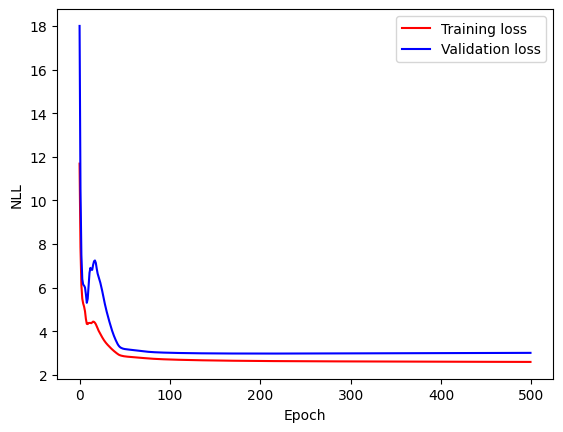

In [30]:
# Obtener la primera secuencia del test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init hidden state como ceros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward 
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

# Graficar la perdida en training y validacion
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#### Preguntas

**Responda** lo siguiente dentro de esta celda

* ¿Qué modelo funcionó mejor? ¿RNN tradicional o el basado en LSTM? ¿Por qué?
* Observen la gráfica obtenida arriba, ¿en qué es diferente a la obtenida a RNN? ¿Es esto mejor o peor? ¿Por qué?
* ¿Por qué LSTM puede funcionar mejor con secuencias largas?

## Parte 3 - Red Neuronal LSTM con PyTorch 

Ahora que ya hemos visto el funcionamiento paso a paso de tanto RNN tradicional como LSTM. Es momento de usar PyTorch. Para esta parte usaremos el mismo dataset generado al inicio. Así mismo, usaremos un ciclo de entrenamiento similar al que hemos usado previamente. 

En la siguiente parte (sí, hay una siguiente parte &#x1F913;) usaremos otro tipo de dataset más formal

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, vocab_size):
        super(Net, self).__init__()
        
        # Capa LSTM con las especificaciones requeridas
        self.lstm = nn.LSTM(input_size=vocab_size,    # Tamaño del vocabulario
                           hidden_size=50,            # 50 hidden states
                           num_layers=1,              # Una sola capa
                           bidirectional=False)       # NO bidireccional
        
        # Layer de salida (output)
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # LSTM regresa el output y el último hidden state (h) y cell state (c)
        x, (h, c) = self.lstm(x)
        
        # Aplanar la salida para una layer feed forward
        x = x.view(-1, self.lstm.hidden_size)
        
        # Layer de output 
        x = self.l_out(x)
        
        return x

net = Net(vocab_size=100)
print(net)

Net(
  (lstm): LSTM(100, 50)
  (l_out): Linear(in_features=50, out_features=100, bias=False)
)


Epoch 0, training loss: 1.2945, validation loss: 1.3799
Epoch 10, training loss: 0.5861, validation loss: 0.5356
Epoch 20, training loss: 0.4209, validation loss: 0.3647
Epoch 30, training loss: 0.3670, validation loss: 0.3350
Epoch 40, training loss: 0.3368, validation loss: 0.2925
Epoch 50, training loss: 0.3199, validation loss: 0.2819
Epoch 60, training loss: 0.3093, validation loss: 0.2757
Epoch 70, training loss: 0.3027, validation loss: 0.2720
Epoch 80, training loss: 0.2986, validation loss: 0.2695
Epoch 90, training loss: 0.2962, validation loss: 0.2686
Epoch 100, training loss: 0.2949, validation loss: 0.2676
Epoch 110, training loss: 0.2939, validation loss: 0.2670
Epoch 120, training loss: 0.2931, validation loss: 0.2668
Epoch 130, training loss: 0.2924, validation loss: 0.2670
Epoch 140, training loss: 0.2918, validation loss: 0.2676
Epoch 150, training loss: 0.2915, validation loss: 0.2682
Epoch 160, training loss: 0.2913, validation loss: 0.2689
Epoch 170, training loss:

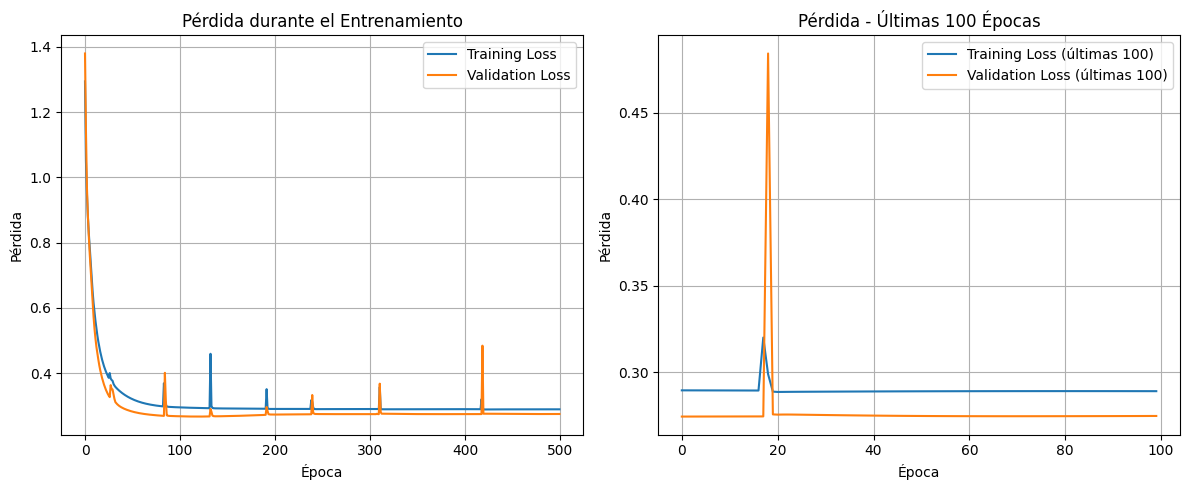

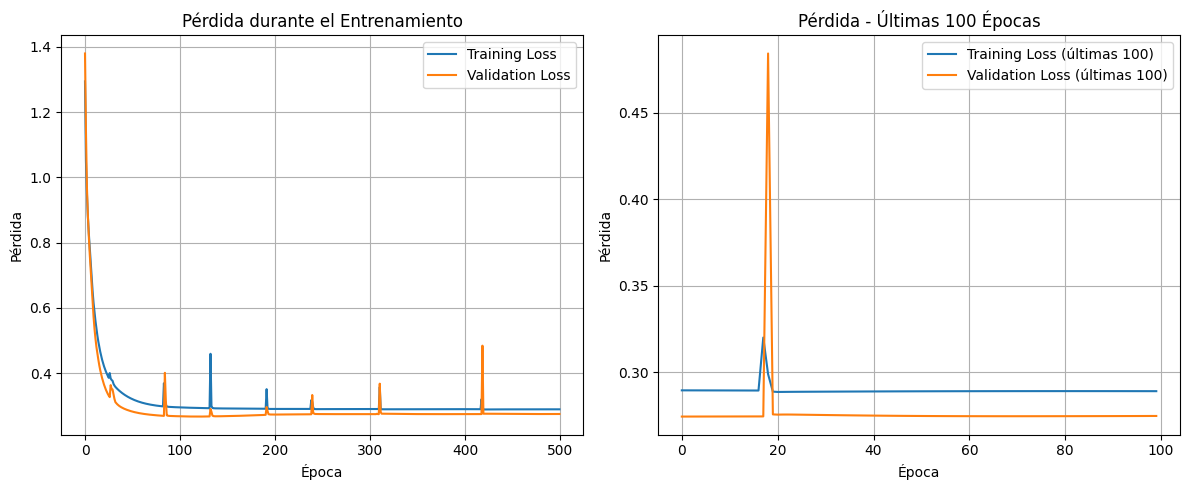

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hyper parámetros
num_epochs = 500

# Init una nueva red (asumiendo que vocab_size está definido)
net = Net(vocab_size)  # Necesita el parámetro vocab_size

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()  # Use CrossEntropy
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)  # Use Adam con lr=3e-4

# Pérdida
training_loss, validation_loss = [], []

# Iteramos cada época
for i in range(num_epochs):
    
    # Pérdidas
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # NOTA 1: Modo evaluación para validation
    net.eval()
        
    # Para cada secuencia en el validation set
    for inputs, targets in validation_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convertir el target a un tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        outputs = net(inputs_one_hot)
        
        # Calcular la pérdida
        loss = criterion(outputs, targets_idx)
        
        # Actualización de la pérdida
        epoch_validation_loss += loss.detach().numpy()
    
    # NOTA 2: Modo entrenamiento para training
    net.train()
    
    # Para cada secuencia en el training set
    for inputs, targets in training_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        import torch
import torch.nn as nn
import torch.nn.functional as F

# Hyper parámetros
num_epochs = 500

# Init una nueva red (asumiendo que vocab_size está definido)
net = Net(vocab_size)  # Necesita el parámetro vocab_size

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()  # Use CrossEntropy
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)  # Use Adam con lr=3e-4

# Pérdida
training_loss, validation_loss = [], []

# Iteramos cada época
for i in range(num_epochs):
    
    # Pérdidas
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # NOTA 1: Modo evaluación para validation
    net.eval()
        
    # Para cada secuencia en el validation set
    for inputs, targets in validation_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convertir el target a un tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        outputs = net(inputs_one_hot)
        
        # Calcular la pérdida
        loss = criterion(outputs, targets_idx)
        
        # Actualización de la pérdida
        epoch_validation_loss += loss.detach().numpy()
    
    # NOTA 2: Modo entrenamiento para training
    net.train()
    
    # Para cada secuencia en el training set
    for inputs, targets in training_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convertir el target a un tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        outputs = net(inputs_one_hot)
        
        # Calcular la pérdida
        loss = criterion(outputs, targets_idx)
        
        # Backward pass
        optimizer.zero_grad()  # Limpiar gradientes
        loss.backward()        # Calcular gradientes
        optimizer.step()       # Actualizar pesos
        
        # Actualización de la pérdida
        epoch_training_loss += loss.detach().numpy()
        
    # Guardar la pérdida para ser graficada
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la pérdida cada 10 épocas
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]:.4f}, validation loss: {validation_loss[-1]:.4f}')

# Graficar las pérdidas
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_loss[-100:], label='Training Loss (últimas 100)')
plt.plot(validation_loss[-100:], label='Validation Loss (últimas 100)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida - Últimas 100 Épocas')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Función para evaluar el modelo
def evaluate_model(net, test_set, criterion):
    """
    Evalúa el modelo en el conjunto de prueba
    """
    net.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, targets in test_set:
            # Preparar datos
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)
            
            # Forward pass
            outputs = net(inputs_one_hot)
            loss = criterion(outputs, targets_idx)
            
            # Calcular accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets_idx).sum().item()
            total_predictions += targets_idx.size(0)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_set)
    accuracy = correct_predictions / total_predictions
    
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    
    return avg_loss, accuracy

# Ejemplo de uso después del entrenamiento
# test_loss, test_accuracy = evaluate_model(net, test_set, criterion)
    # Convertir el target a un tensor
    targets_idx = torch.LongTensor(targets_idx)
    
    # Forward pass
    outputs = net(inputs_one_hot)
    
    # Calcular la pérdida
    loss = criterion(outputs, targets_idx)
    
    # Backward pass
    optimizer.zero_grad()  # Limpiar gradientes
    loss.backward()        # Calcular gradientes
    optimizer.step()       # Actualizar pesos
    
    # Actualización de la pérdida
    epoch_training_loss += loss.detach().numpy()
        
    # Guardar la pérdida para ser graficada
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la pérdida cada 10 épocas
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]:.4f}, validation loss: {validation_loss[-1]:.4f}')

# Graficar las pérdidas
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_loss[-100:], label='Training Loss (últimas 100)')
plt.plot(validation_loss[-100:], label='Validation Loss (últimas 100)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida - Últimas 100 Épocas')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Función para evaluar el modelo
def evaluate_model(net, test_set, criterion):
    """
    Evalúa el modelo en el conjunto de prueba
    """
    net.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, targets in test_set:
            # Preparar datos
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)
            
            # Forward pass
            outputs = net(inputs_one_hot)
            loss = criterion(outputs, targets_idx)
            
            # Calcular accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets_idx).sum().item()
            total_predictions += targets_idx.size(0)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_set)
    accuracy = correct_predictions / total_predictions
    
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    
    return avg_loss, accuracy

# Ejemplo de uso después del entrenamiento
# test_loss, test_accuracy = evaluate_model(net, test_set, criterion)

In [35]:

with tick.marks(5):        
    assert compare_numbers(new_representation(training_loss[-1]), "3c3d", '0x1.28f5c28f5c28fp-2')
    
with tick.marks(5):        
    assert compare_numbers(new_representation(validation_loss[-1]), "3c3d", '0x1.28f5c28f5c28fp-2')

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


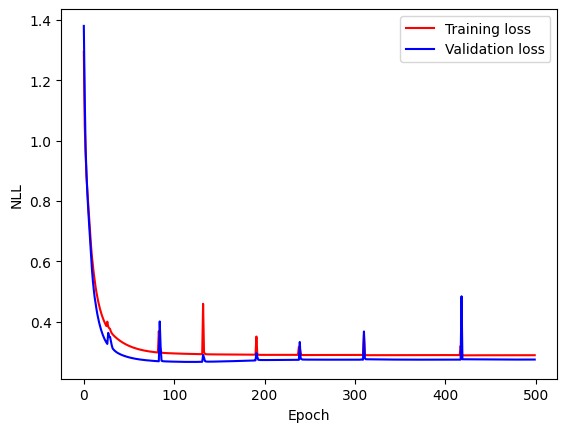

In [36]:
# Obtener la primera secuencia del test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convertir el input a un tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convertir el target a un tensor
targets_idx = torch.LongTensor(targets_idx)

# Aprox 1 linea para el Forward 
outputs = net(inputs_one_hot)

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[torch.argmax(output).item()] for output in outputs])

# Graficar la perdida en training y validacion
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#### Preguntas

**Responda** lo siguiente dentro de esta celda

* Compare las graficas obtenidas en el LSTM "a mano" y el LSTM "usando PyTorch, ¿cuál cree que es mejor? ¿Por qué?
* Compare la secuencia target y la predicha de esta parte, ¿en qué parte falló el modelo?
* ¿Qué sucede en el código donde se señala "NOTA 1" y "NOTA 2"? ¿Para qué son necesarias estas líneas?

## Parte 4 - Segunda Red Neuronal LSTM con PyTorch 

Para esta parte será un poco menos guiada, por lo que se espera que puedan generar un modelo de Red Neuronal con LSTM para solventar un problema simple. Lo que se evaluará es la métrica final, y solamente se dejarán las generalidades de la implementación. El objetivo de esta parte, es dejar que ustedes exploren e investiguen un poco más por su cuenta. 

En este parte haremos uso de las redes LSTM pero para predicción de series de tiempo. Entonces lo que se busca es que dado un mes y un año, se debe predecir el número de pasajeros en unidades de miles. Los datos a usar son de 1949 a 1960.

Basado del blog "LSTM for Time Series Prediction in PyTorch" de Adrian Tam.

In [37]:
# Seed all
import torch
import random
import numpy as np


random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)  # Multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [38]:
import pandas as pd

url_data = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataset = pd.read_csv(url_data)
dataset.head(10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


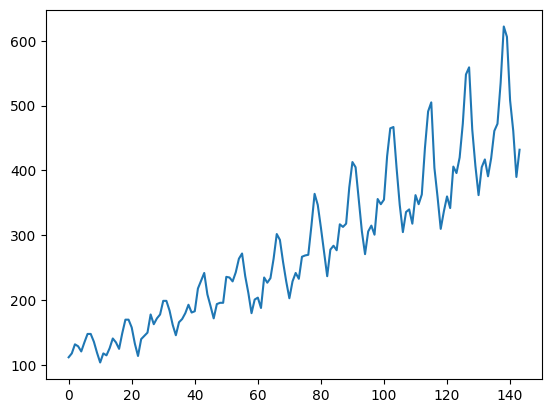

In [39]:
# Dibujemos la serie de tiempo
time_series = dataset[["Passengers"]].values.astype('float32')

plt.plot(time_series)
plt.show()

Esta serie de tiempo comprende 144 pasos de tiempo. El gráfico indica claramente una tendencia al alza y hay patrones periódicos en los datos que corresponden al período de vacaciones de verano. Por lo general, se recomienda "eliminar la tendencia" de la serie temporal eliminando el componente de tendencia lineal y normalizándolo antes de continuar con el procesamiento. Sin embargo, por simplicidad de este ejercicios, vamos a omitir estos pasos.

Ahora necesitamos dividir nuestro dataset en training, validation y test set. A diferencia de otro tipo de datasets, cuando se trabaja en este tipo de proyectos, la división se debe hacer sin "revolver" los datos. Para esto, podemos hacerlo con NumPy

In [40]:
# En esta ocasion solo usaremos train y test, validation lo omitiremos para simpleza del ejercicio
# NO CAMBIEN NADA DE ESTA CELDA POR FAVOR
p_train=0.8
p_test=0.2

# Definimos el tamaño de las particiones
num_train = int(len(time_series)*p_train)
num_test = int(len(time_series)*p_test)


# Dividir las secuencias en las particiones
train = time_series[:num_train]
test = time_series[num_train:]

El aspecto más complicado es determinar el método por el cual la red debe predecir la serie temporal. Por lo general, la predicción de series temporales se realiza en función de una ventana. En otras palabras, recibe datos del tiempo t1 al t2, y su tarea es predecir para el tiempo t3 (o más adelante). El tamaño de la ventana, denotado por w, dicta cuántos datos puede considerar el modelo al hacer la predicción. Este parámetro también se conoce como **look back period** (período retrospectivo).

Entonces, creemos una función para obtener estos datos, dado un look back period. Además, debemos asegurarnos de transformar estos datos a tensores para poder ser usados con PyTorch.

Esta función está diseñada para crear ventanas en la serie de tiempo mientras predice un paso de tiempo en el futuro inmediato. Su propósito es convertir una serie de tiempo en un tensor con dimensiones (muestras de ventana, pasos de tiempo, características). Dada una serie de tiempo con t pasos de tiempo, puede producir aproximadamente (t - ventana + 1) ventanas, donde "ventana" denota el tamaño de cada ventana. Estas ventanas pueden comenzar desde cualquier paso de tiempo dentro de la serie de tiempo, siempre que no se extiendan más allá de sus límites.

Cada ventana contiene múltiples pasos de tiempo consecutivos con sus valores correspondientes, y cada paso de tiempo puede tener múltiples características. Sin embargo, en este conjunto de datos específico, solo hay una función disponible.

La elección del diseño garantiza que tanto la "característica" como el "objetivo" tengan la misma forma. Por ejemplo, para una ventana de tres pasos de tiempo, la "característica" corresponde a la serie de tiempo de t-3 a t-1, y el "objetivo" cubre los pasos de tiempo de t-2 a t. Aunque estamos principalmente interesados en predecir t+1, la información de t-2 a t es valiosa durante el entrenamiento.

Es importante tener en cuenta que la serie temporal de entrada se representa como una matriz 2D, mientras que la salida de la función `create_timeseries_dataset()` será un tensor 3D. Para demostrarlo, usemos lookback=1 y verifiquemos la forma del tensor de salida en consecuencia.

In [41]:
import torch

def create_timeseries_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# EL VALOR DE LB SÍ LO PUEDEN CAMBIAR SI LO CONSIDERAN NECESARIO
lb = 4
X_train, y_train = create_timeseries_dataset(train, lookback=lb)
#X_validation, y_validation = create_timeseries_dataset(validation, lookback=lb)
X_test, y_test = create_timeseries_dataset(test, lookback=lb)

print(X_train.shape, y_train.shape)
#print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([111, 4, 1]) torch.Size([111, 4, 1])
torch.Size([25, 4, 1]) torch.Size([25, 4, 1])


/tmp/ipykernel_14836/2018909527.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X), torch.tensor(y)


Ahora necesitamos crear una clase que definirá nuestro modelo de red neuronal con LSTM. Noten que acá solo se dejaran las firmas de las funciones necesarias, ustedes deberán decidir que arquitectura con LSTM implementar, con la finalidad de superar cierto threshold de métrica de desempeño mencionado abajo.

In [42]:
import torch.nn as nn

# NOTA: Moví el numero de iteraciones para que no se borre al ser evaluado
# Pueden cambiar el número de epocas en esta ocasión con tal de llegar al valor de la metrica de desempeño
n_epochs = 6000

class CustomModelLSTM(nn.Module):
    def __init__(self):
        super(CustomModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm(x)
        x = self.linear(x)
        return x

La función nn.LSTM() produce una tupla como salida. El primer elemento de esta tupla consiste en los hidden states generados, donde cada paso de tiempo de la entrada tiene su correspondiente hidden state. El segundo elemento contiene la memoria y los hidden states de la unidad LSTM, pero no se usan en este contexto particular.

La capa LSTM se configura con la opción `batch_first=True` porque los tensores de entrada se preparan en la dimensión de (muestra de ventana, pasos de tiempo, características). Con esta configuración, se crea un batch tomando muestras a lo largo de la primera dimensión.

Para generar un único resultado de regresión, la salida de los estados ocultos se procesa aún más utilizando una capa fully connected. Dado que la salida de LSTM corresponde a un valor para cada paso de tiempo de entrada, se debe seleccionar solo la salida del último paso de tiempo.

In [43]:
import torch.optim as optim
import torch.utils.data as data

# NOTEN QUE ESTOY PONIENDO DE NUEVO LOS SEEDS PARA SER CONSTANTES
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)  # Multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
############
 
model = CustomModelLSTM()
# Optimizador y perdida
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# Observen como podemos también definir un DataLoader de forma snecilla
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 

# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/tmp/ipykernel_14836/3596878564.py:57: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_14836/3596878564.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 254.8949, test RMSE 449.7705
Epoch 100: train RMSE 207.2679, test RMSE 399.2317
Epoch 200: train RMSE 169.3057, test RMSE 357.2211
Epoch 300: train RMSE 138.3868, test RMSE 320.3749
Epoch 400: train RMSE 114.7543, test RMSE 288.4024
Epoch 500: train RMSE 89.9956, test RMSE 252.9015
Epoch 600: train RMSE 73.0530, test RMSE 223.9537
Epoch 700: train RMSE 62.6046, test RMSE 204.3255
Epoch 800: train RMSE 52.1204, test RMSE 182.2824
Epoch 900: train RMSE 45.9474, test RMSE 168.0043
Epoch 1000: train RMSE 39.5882, test RMSE 150.5797
Epoch 1100: train RMSE 35.2145, test RMSE 136.2751
Epoch 1200: train RMSE 31.9739, test RMSE 124.1116
Epoch 1300: train RMSE 29.6999, test RMSE 113.7606
Epoch 1400: train RMSE 28.8522, test RMSE 105.4372
Epoch 1500: train RMSE 26.7302, test RMSE 97.7510
Epoch 1600: train RMSE 26.1211, test RMSE 91.5941
Epoch 1700: train RMSE 25.3340, test RMSE 86.9250
Epoch 1800: train RMSE 26.6338, test RMSE 82.9466
Epoch 1900: train RMSE 24.7098, test RMSE 

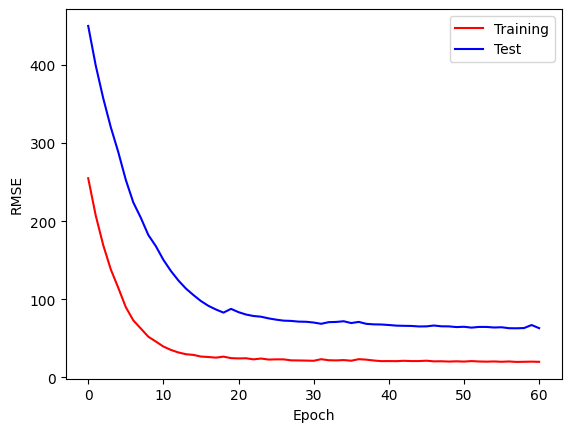

In [44]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

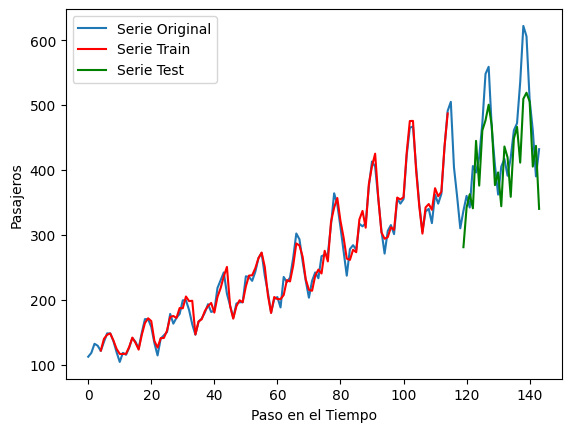

In [45]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(time_series) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lb : num_train] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(time_series) * np.nan
    test_plot[num_train + lb : len(time_series)] = model(X_test)[:, -1, :]

    
plt.figure()
plt.plot(time_series, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

**Nota:** Lo que se estará evaluando es el RMSE tanto en training como en test. Se evaluará que en training sea **menor a 22**, mientras que en testing sea **menor a 70**.

In [46]:
float(loss_test[len(loss_test)-1])
float(test_rmse)
loss_train

with tick.marks(7):        
    assert loss_train[-1] < 22 
    
with tick.marks(7):        
    assert train_rmse < 22 
    
with tick.marks(7):        
    assert loss_test[-1] < 70 
    
with tick.marks(7):        
    assert test_rmse < 70 
    

In [47]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 



La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
